In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
from dgl.nn.pytorch import EdgeWeightNorm
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [2]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
name = "cic_ids_2017_5_percent"
# name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

suffix = "_with_centralities"

dataset = datasets[name]

In [3]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}

    
results_final["e_gcn"] = {}
results_final["e_gcn_res"] = {}

results_final["e_graph_sage"] = {}
results_final["e_graph_sage_res"] = {}

results_final["e_gat"] = {}
results_final["e_gat_res"] = {}


results_final

{'name': 'cic_ids_2017_5_percent',
 'configuration': {'num_epochs': 100, 'batch_size': 128},
 'accuracy': {},
 'time_elapsed': {},
 'e_gcn': {},
 'e_gcn_res': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'e_gat': {},
 'e_gat_res': {}}

In [4]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20241109-190455'

In [5]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)
    
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [6]:
with open(f"datasets/{name}/training_graph{suffix}.pkl", "rb") as f:
    G = pickle.load(f)

In [7]:
G = from_networkx(G,edge_attrs=['h',dataset.label_col] )

In [8]:
num_features = G.edata['h'].shape[1]
num_features

37

In [9]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(G.edata[dataset.label_col].cpu().numpy()),
                                                 y = G.edata[dataset.label_col].cpu().numpy())

In [11]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight = class_weights)

In [12]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [13]:
def train_gnn(model_class, Graph, residual, num_neighbors = None, norm=None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if norm:
        edge_weight = th.ones(Graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(Graph, edge_weight)
        Graph.edata['norm_weight'] = norm_edge_weight
        
    if num_neighbors:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, residual=residual)

        
    opt = th.optim.Adam(model.parameters())

    for epoch in range(1,num_epochs):
    #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features,edge_features)
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

    return model

### Training EGCN

In [14]:
model_gcn = train_gnn(EGCN, G, False, None)

Epoch: 1  Training acc: 0.8035154342651367
Epoch: 2  Training acc: 0.8035154342651367
Epoch: 3  Training acc: 0.8035154342651367
Epoch: 4  Training acc: 0.8032929301261902
Epoch: 5  Training acc: 0.1971520483493805
Epoch: 6  Training acc: 0.19651490449905396
Epoch: 7  Training acc: 0.19651490449905396
Epoch: 8  Training acc: 0.19651490449905396
Epoch: 9  Training acc: 0.19651490449905396
Epoch: 10  Training acc: 0.19652500748634338
Epoch: 11  Training acc: 0.1968688666820526
Epoch: 12  Training acc: 0.40016990900039673
Epoch: 13  Training acc: 0.6622504591941833
Epoch: 14  Training acc: 0.7430469989776611
Epoch: 15  Training acc: 0.7699993848800659
Epoch: 16  Training acc: 0.8452335000038147
Epoch: 17  Training acc: 0.8657132983207703
Epoch: 18  Training acc: 0.8677056431770325
Epoch: 19  Training acc: 0.8681607842445374
Epoch: 20  Training acc: 0.8682214617729187
Epoch: 21  Training acc: 0.868019163608551
Epoch: 22  Training acc: 0.8674022555351257
Epoch: 23  Training acc: 0.866643726

### Training EGCN residual

In [15]:
model_gcn_res = train_gnn(EGCN, G, True, None)

Epoch: 1  Training acc: 0.665668785572052
Epoch: 2  Training acc: 0.6806671023368835
Epoch: 3  Training acc: 0.6977689862251282
Epoch: 4  Training acc: 0.7153360843658447
Epoch: 5  Training acc: 0.7282105088233948
Epoch: 6  Training acc: 0.7414490580558777
Epoch: 7  Training acc: 0.7629503011703491
Epoch: 8  Training acc: 0.7767754197120667
Epoch: 9  Training acc: 0.7852909564971924
Epoch: 10  Training acc: 0.7885070443153381
Epoch: 11  Training acc: 0.7926940321922302
Epoch: 12  Training acc: 0.805305540561676
Epoch: 13  Training acc: 0.8085013628005981
Epoch: 14  Training acc: 0.8119702935218811
Epoch: 15  Training acc: 0.818463146686554
Epoch: 16  Training acc: 0.8267865180969238
Epoch: 17  Training acc: 0.8378810286521912
Epoch: 18  Training acc: 0.8499969840049744
Epoch: 19  Training acc: 0.8679989576339722
Epoch: 20  Training acc: 0.8775157332420349
Epoch: 21  Training acc: 0.8905014395713806
Epoch: 22  Training acc: 0.9007969498634338
Epoch: 23  Training acc: 0.9121847152709961


### Training EGraphSage 

In [16]:
model_sage = train_gnn(EGRAPHSAGE, G, False, [25,10])

Epoch: 1  Training acc: 0.788051962852478
Epoch: 2  Training acc: 0.9608001708984375
Epoch: 3  Training acc: 0.9628936648368835
Epoch: 4  Training acc: 0.9392180442810059
Epoch: 5  Training acc: 0.962671160697937
Epoch: 6  Training acc: 0.971712589263916
Epoch: 7  Training acc: 0.9880256652832031
Epoch: 8  Training acc: 0.9949837327003479
Epoch: 9  Training acc: 0.9985436797142029
Epoch: 10  Training acc: 0.9964703917503357
Epoch: 11  Training acc: 0.9802483916282654
Epoch: 12  Training acc: 0.9954994916915894
Epoch: 13  Training acc: 0.9823520183563232
Epoch: 14  Training acc: 0.998169481754303
Epoch: 15  Training acc: 0.9980986714363098
Epoch: 16  Training acc: 0.9981593489646912
Epoch: 17  Training acc: 0.998169481754303
Epoch: 18  Training acc: 0.9982402324676514
Epoch: 19  Training acc: 0.9981593489646912
Epoch: 20  Training acc: 0.9981391429901123
Epoch: 21  Training acc: 0.998088538646698
Epoch: 22  Training acc: 0.9981290102005005
Epoch: 23  Training acc: 0.998078465461731
Epoc

### Training EGraphSage residual

In [17]:
model_sage_res = train_gnn(EGRAPHSAGE, G, True, [25,10])

Epoch: 1  Training acc: 0.41366127133369446
Epoch: 2  Training acc: 0.7075183391571045
Epoch: 3  Training acc: 0.8380023837089539
Epoch: 4  Training acc: 0.8511599898338318
Epoch: 5  Training acc: 0.9604158401489258
Epoch: 6  Training acc: 0.9681830406188965
Epoch: 7  Training acc: 0.9784279465675354
Epoch: 8  Training acc: 0.9789741039276123
Epoch: 9  Training acc: 0.9934666752815247
Epoch: 10  Training acc: 0.9946702122688293
Epoch: 11  Training acc: 0.9935476183891296
Epoch: 12  Training acc: 0.9919294714927673
Epoch: 13  Training acc: 0.9884504079818726
Epoch: 14  Training acc: 0.9959141612052917
Epoch: 15  Training acc: 0.9952466487884521
Epoch: 16  Training acc: 0.9980683326721191
Epoch: 17  Training acc: 0.9980379939079285
Epoch: 18  Training acc: 0.9990392327308655
Epoch: 19  Training acc: 0.9895021915435791
Epoch: 20  Training acc: 0.9880660772323608
Epoch: 21  Training acc: 0.9974918365478516
Epoch: 22  Training acc: 0.988136887550354
Epoch: 23  Training acc: 0.98659962415695

### Training EGAT

In [18]:
model_gat = train_gnn(EGAT, G, False, None)

Epoch: 1  Training acc: 0.8776472210884094
Epoch: 2  Training acc: 0.9280931949615479
Epoch: 3  Training acc: 0.977001965045929
Epoch: 4  Training acc: 0.9895831346511841
Epoch: 5  Training acc: 0.9956006407737732
Epoch: 6  Training acc: 0.9980379939079285
Epoch: 7  Training acc: 0.998078465461731
Epoch: 8  Training acc: 0.9981593489646912
Epoch: 9  Training acc: 0.99817955493927
Epoch: 10  Training acc: 0.99817955493927
Epoch: 11  Training acc: 0.99817955493927
Epoch: 12  Training acc: 0.99817955493927
Epoch: 13  Training acc: 0.99817955493927
Epoch: 14  Training acc: 0.99817955493927
Epoch: 15  Training acc: 0.99817955493927
Epoch: 16  Training acc: 0.99817955493927
Epoch: 17  Training acc: 0.99817955493927
Epoch: 18  Training acc: 0.99817955493927
Epoch: 19  Training acc: 0.99817955493927
Epoch: 20  Training acc: 0.99817955493927
Epoch: 21  Training acc: 0.99817955493927
Epoch: 22  Training acc: 0.99817955493927
Epoch: 23  Training acc: 0.99817955493927
Epoch: 24  Training acc: 0.99

### Training EGAT residual

In [19]:
model_gat_res = train_gnn(EGAT, G, True, None)

Epoch: 1  Training acc: 0.5888873338699341
Epoch: 2  Training acc: 0.9157851338386536
Epoch: 3  Training acc: 0.9768806099891663
Epoch: 4  Training acc: 0.9829891324043274
Epoch: 5  Training acc: 0.9879851937294006
Epoch: 6  Training acc: 0.9951354265213013
Epoch: 7  Training acc: 0.9967940449714661
Epoch: 8  Training acc: 0.9970468878746033
Epoch: 9  Training acc: 0.9972389936447144
Epoch: 10  Training acc: 0.9973806142807007
Epoch: 11  Training acc: 0.9974311590194702
Epoch: 12  Training acc: 0.997441291809082
Epoch: 13  Training acc: 0.9975121021270752
Epoch: 14  Training acc: 0.9975626468658447
Epoch: 15  Training acc: 0.9976536631584167
Epoch: 16  Training acc: 0.9976840019226074
Epoch: 17  Training acc: 0.9979469776153564
Epoch: 18  Training acc: 0.9979469776153564
Epoch: 19  Training acc: 0.9979469776153564
Epoch: 20  Training acc: 0.9980278611183167
Epoch: 21  Training acc: 0.9980481266975403
Epoch: 22  Training acc: 0.9981188774108887
Epoch: 23  Training acc: 0.998118877410888

# Testing

In [20]:
with open(f"datasets/{name}/testing_graph{suffix}.pkl", "rb") as f:
    G_test = pickle.load(f)

In [21]:
G_test = from_networkx(G_test,edge_attrs=['h',dataset.label_col] )

In [22]:
actual_label = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),num_features)

In [23]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [24]:
def test_gnn(model, graph):
    start_time = timeit.default_timer()
    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)


In [25]:

def calculate_FPR_FNR(cm):
 
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
 
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
 
    return FPR, FNR

In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path = None):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [27]:
actual, test_pred, elapsed = test_gnn(model_gcn, G_test)

0.20670079998672009 seconds


In [28]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

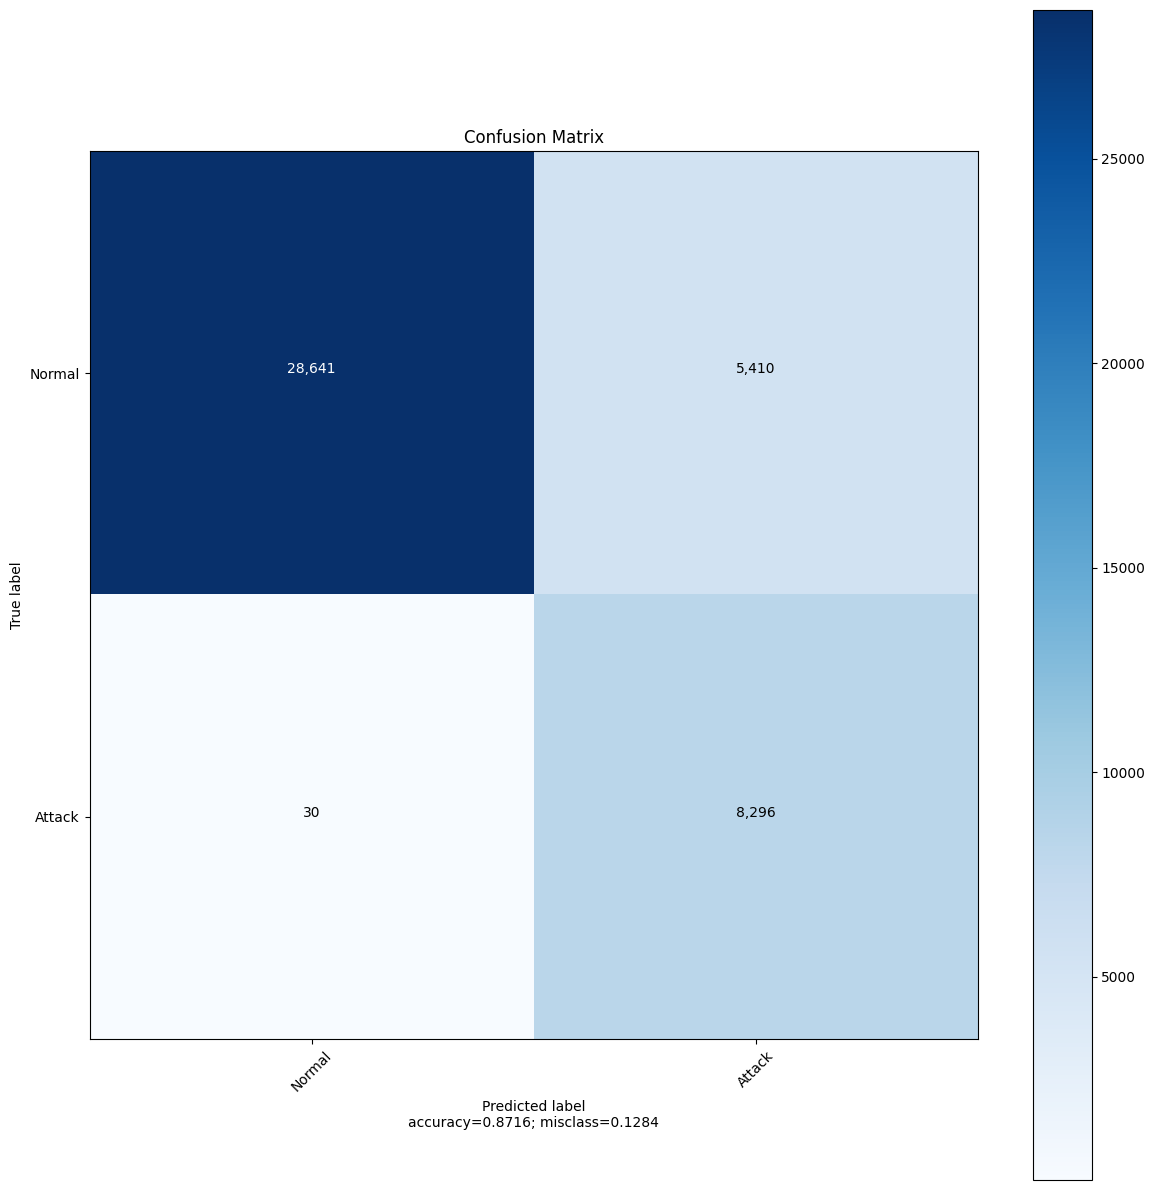

In [29]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn.png')

In [30]:
FPR, FNR = calculate_FPR_FNR(cm)

In [31]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn"]["elapsed"] = elapsed
results_final["e_gcn"]["classification_report"] = cr
results_final["e_gcn"]["FPR"] = FPR
results_final["e_gcn"]["FNR"] = FNR
results_final["accuracy"]["e_gcn"] = cr["accuracy"]
results_final["time_elapsed"]["e_gcn"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.6053    0.9964    0.7531      8326
      Normal     0.9990    0.8411    0.9133     34051

    accuracy                         0.8716     42377
   macro avg     0.8021    0.9188    0.8332     42377
weighted avg     0.9216    0.8716    0.8818     42377



### Testing EGCN residual

In [32]:
actual, test_pred, elapsed = test_gnn(model_gcn_res, G_test)

0.20751729980111122 seconds


In [33]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

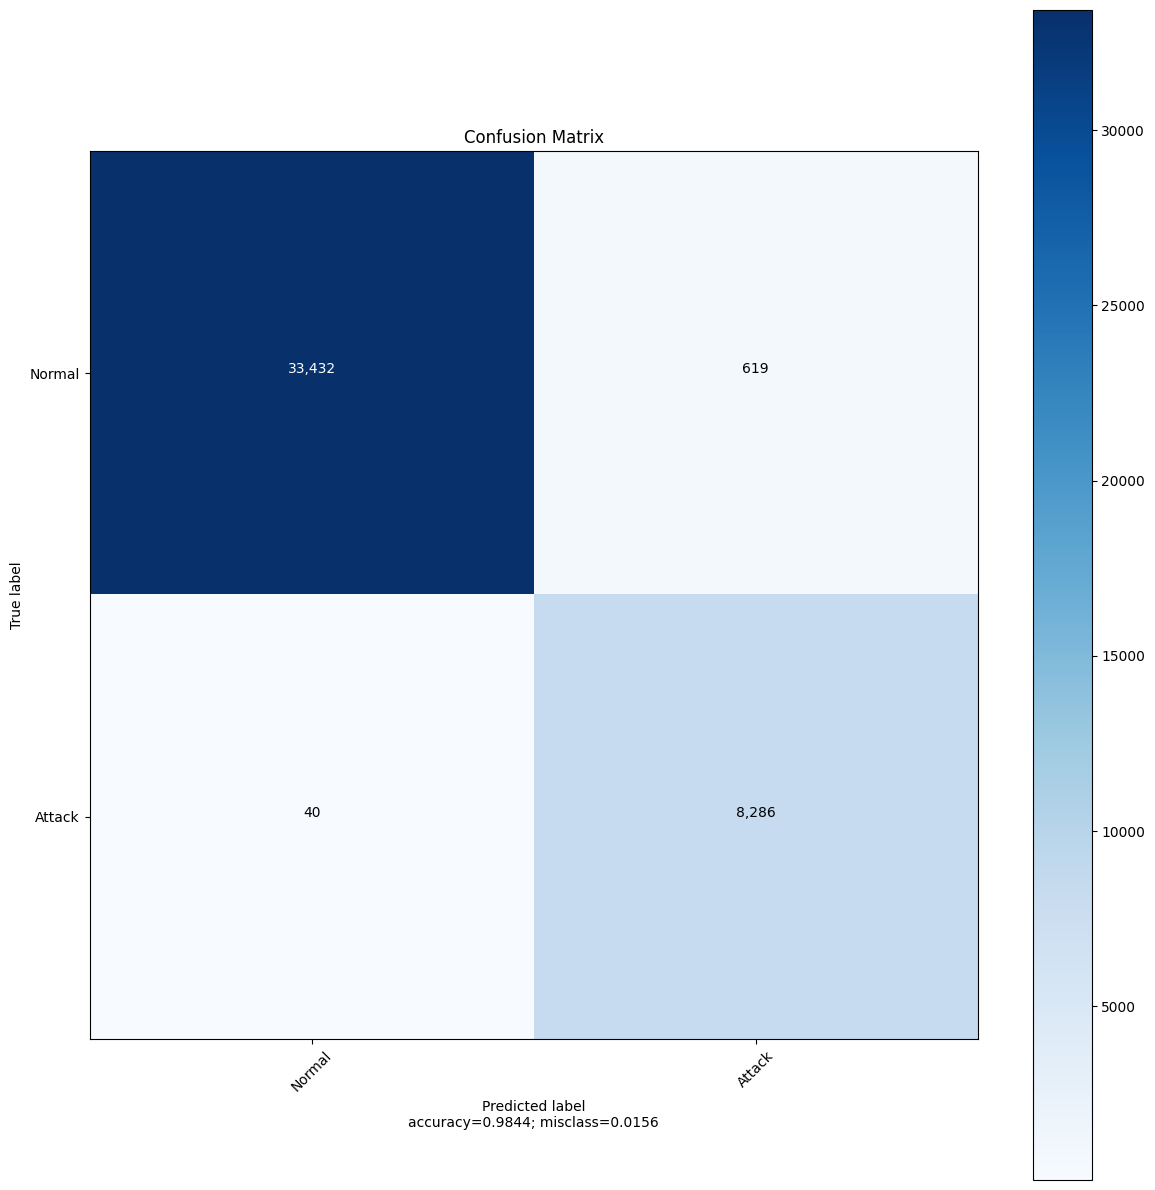

In [34]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn_res.png')

In [35]:
FPR, FNR = calculate_FPR_FNR(cm)

In [36]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn_res"]["elapsed"] = elapsed
results_final["e_gcn_res"]["classification_report"] = cr
results_final["e_gcn_res"]["FPR"] = FPR
results_final["e_gcn_res"]["FNR"] = FNR
results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_gcn_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9305    0.9952    0.9618      8326
      Normal     0.9988    0.9818    0.9902     34051

    accuracy                         0.9844     42377
   macro avg     0.9646    0.9885    0.9760     42377
weighted avg     0.9854    0.9844    0.9846     42377



### Testing EGraphSage

In [37]:
actual, test_pred, elapsed = test_gnn(model_sage, G_test)

0.110466199927032 seconds


In [38]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

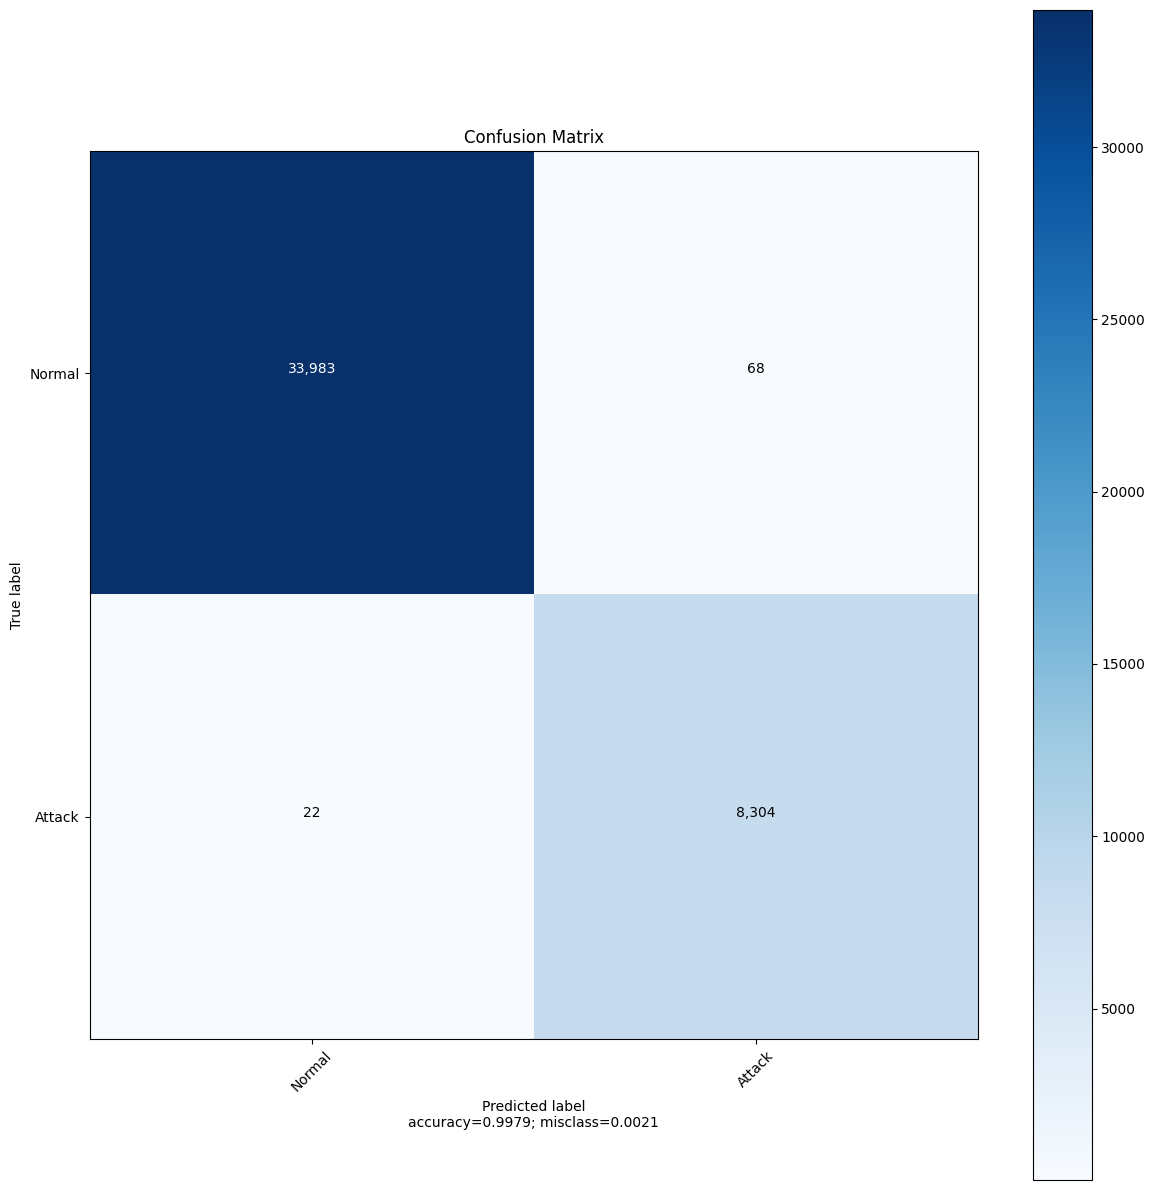

In [39]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage.png')

In [40]:
FPR, FNR = calculate_FPR_FNR(cm)

In [41]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage"]["elapsed"] = elapsed
results_final["e_graph_sage"]["classification_report"] = cr
results_final["e_graph_sage"]["FPR"] = FPR
results_final["e_graph_sage"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]
results_final["time_elapsed"]["e_graph_sage"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9919    0.9974    0.9946      8326
      Normal     0.9994    0.9980    0.9987     34051

    accuracy                         0.9979     42377
   macro avg     0.9956    0.9977    0.9966     42377
weighted avg     0.9979    0.9979    0.9979     42377



### Testing EGraphSage residual

In [42]:
actual, test_pred, elapsed = test_gnn(model_sage_res, G_test)

0.13117680046707392 seconds


In [43]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

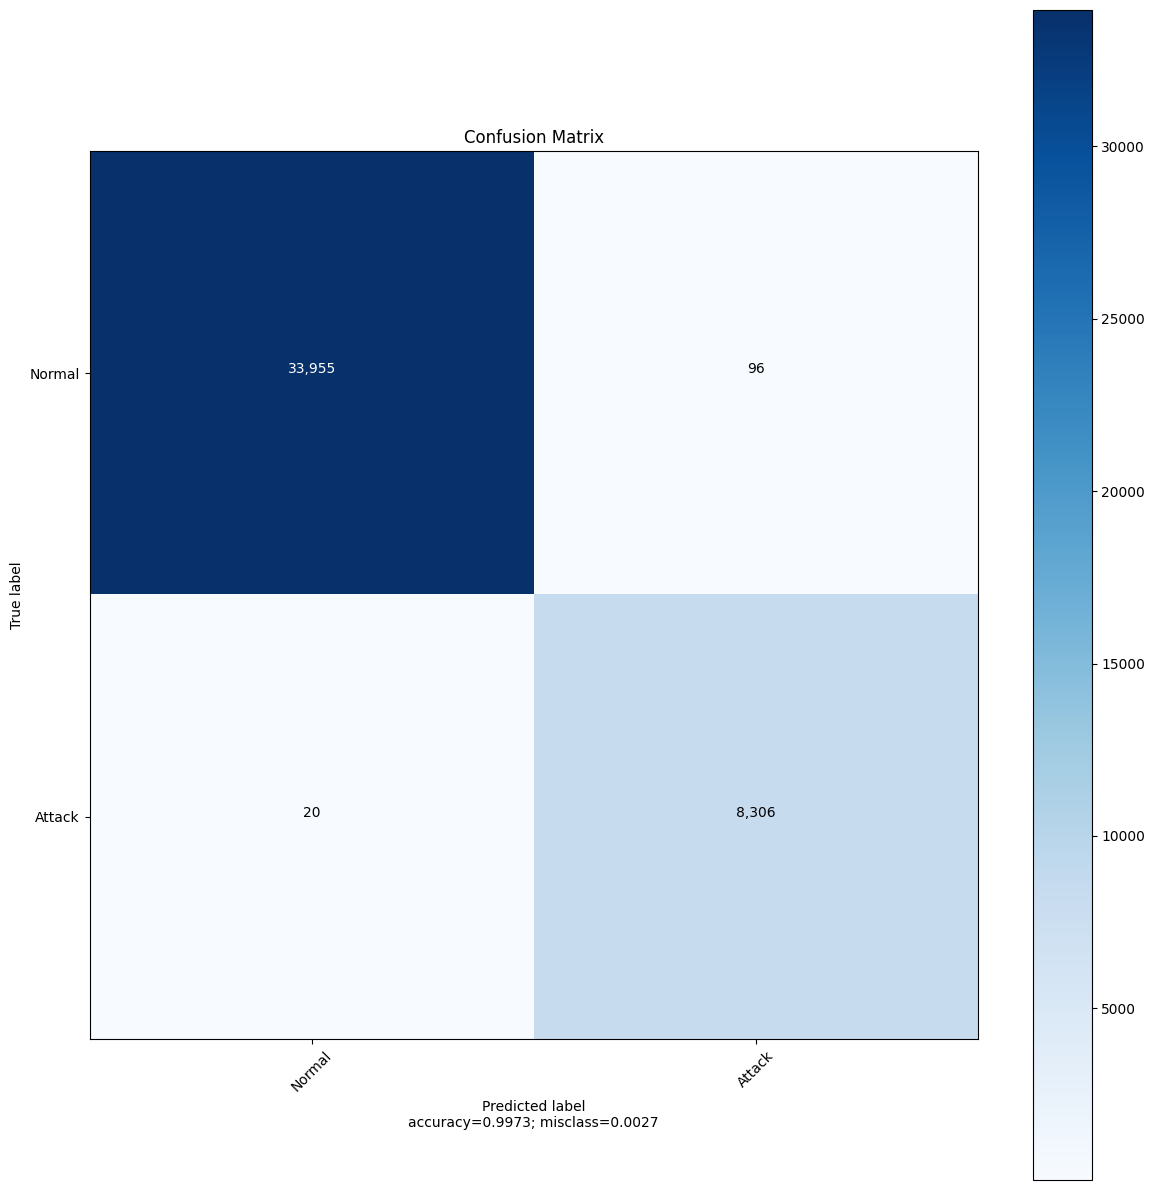

In [44]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage_res.png')

In [45]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage_res"]["elapsed"] = elapsed
results_final["e_graph_sage_res"]["classification_report"] = cr
results_final["e_graph_sage_res"]["FPR"] = FPR
results_final["e_graph_sage_res"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_graph_sage_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9886    0.9976    0.9931      8326
      Normal     0.9994    0.9972    0.9983     34051

    accuracy                         0.9973     42377
   macro avg     0.9940    0.9974    0.9957     42377
weighted avg     0.9973    0.9973    0.9973     42377



### Testing EGAT

In [46]:
actual, test_pred, elapsed = test_gnn(model_gat, G_test)

0.46656510047614574 seconds


In [47]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

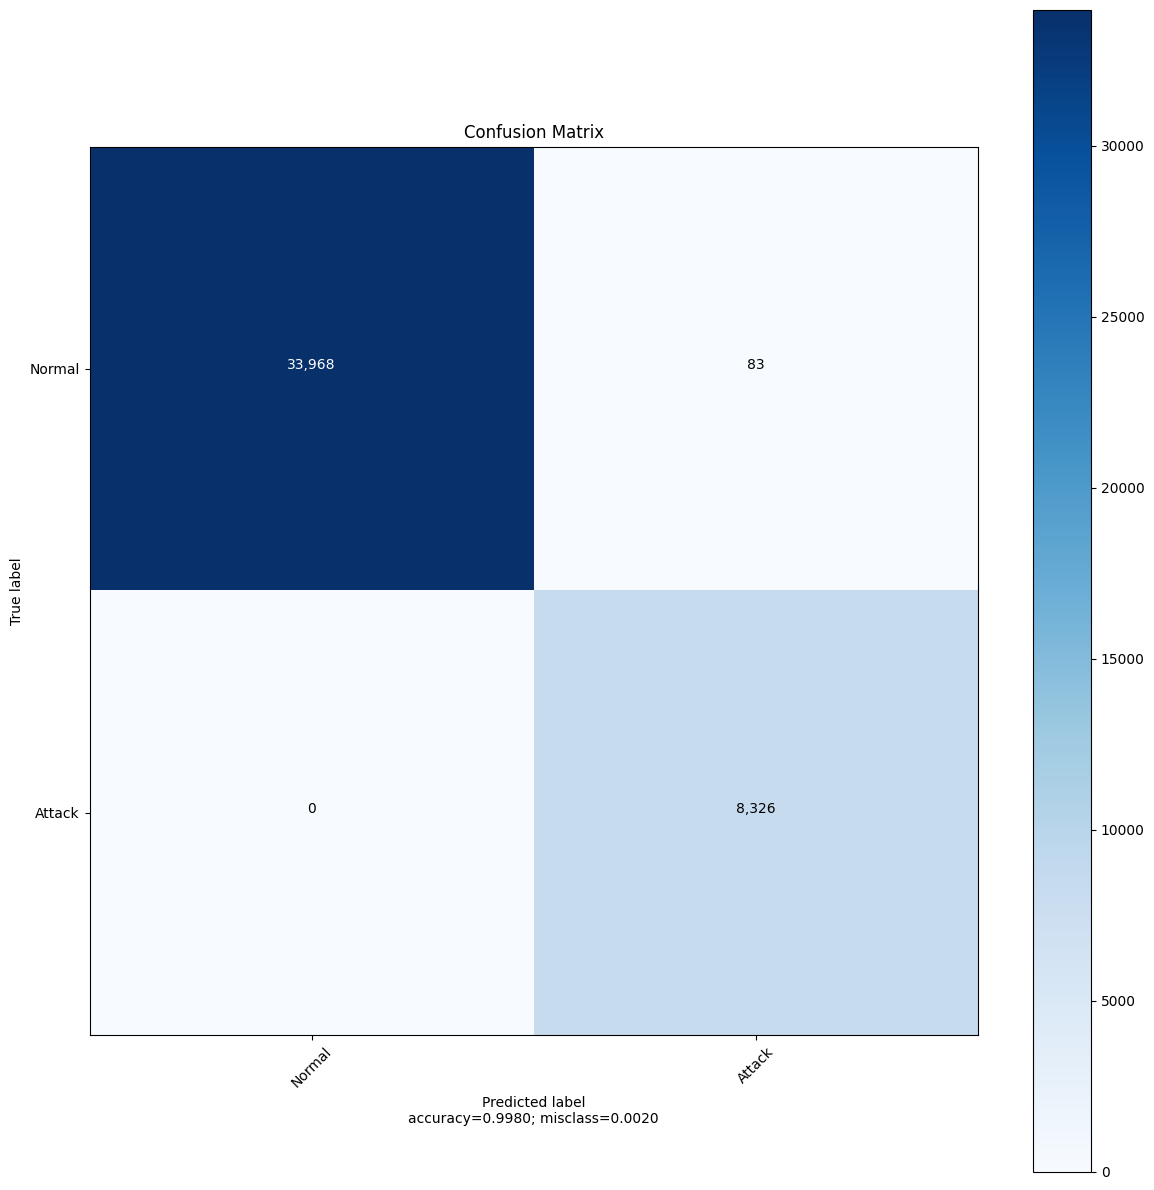

In [48]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat.png')

In [49]:
FPR, FNR = calculate_FPR_FNR(cm)

In [50]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat"]["elapsed"] = elapsed
results_final["e_gat"]["classification_report"] = cr
results_final["e_gat"]["FPR"] = FPR
results_final["e_gat"]["FNR"] = FNR
results_final["accuracy"]["e_gat"] = cr["accuracy"]
results_final["time_elapsed"]["e_gat"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9901    1.0000    0.9950      8326
      Normal     1.0000    0.9976    0.9988     34051

    accuracy                         0.9980     42377
   macro avg     0.9951    0.9988    0.9969     42377
weighted avg     0.9981    0.9980    0.9980     42377



### Testing EGAT residual

In [51]:
actual, test_pred, elapsed = test_gnn(model_gat_res, G_test)

0.4658617004752159 seconds


In [52]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

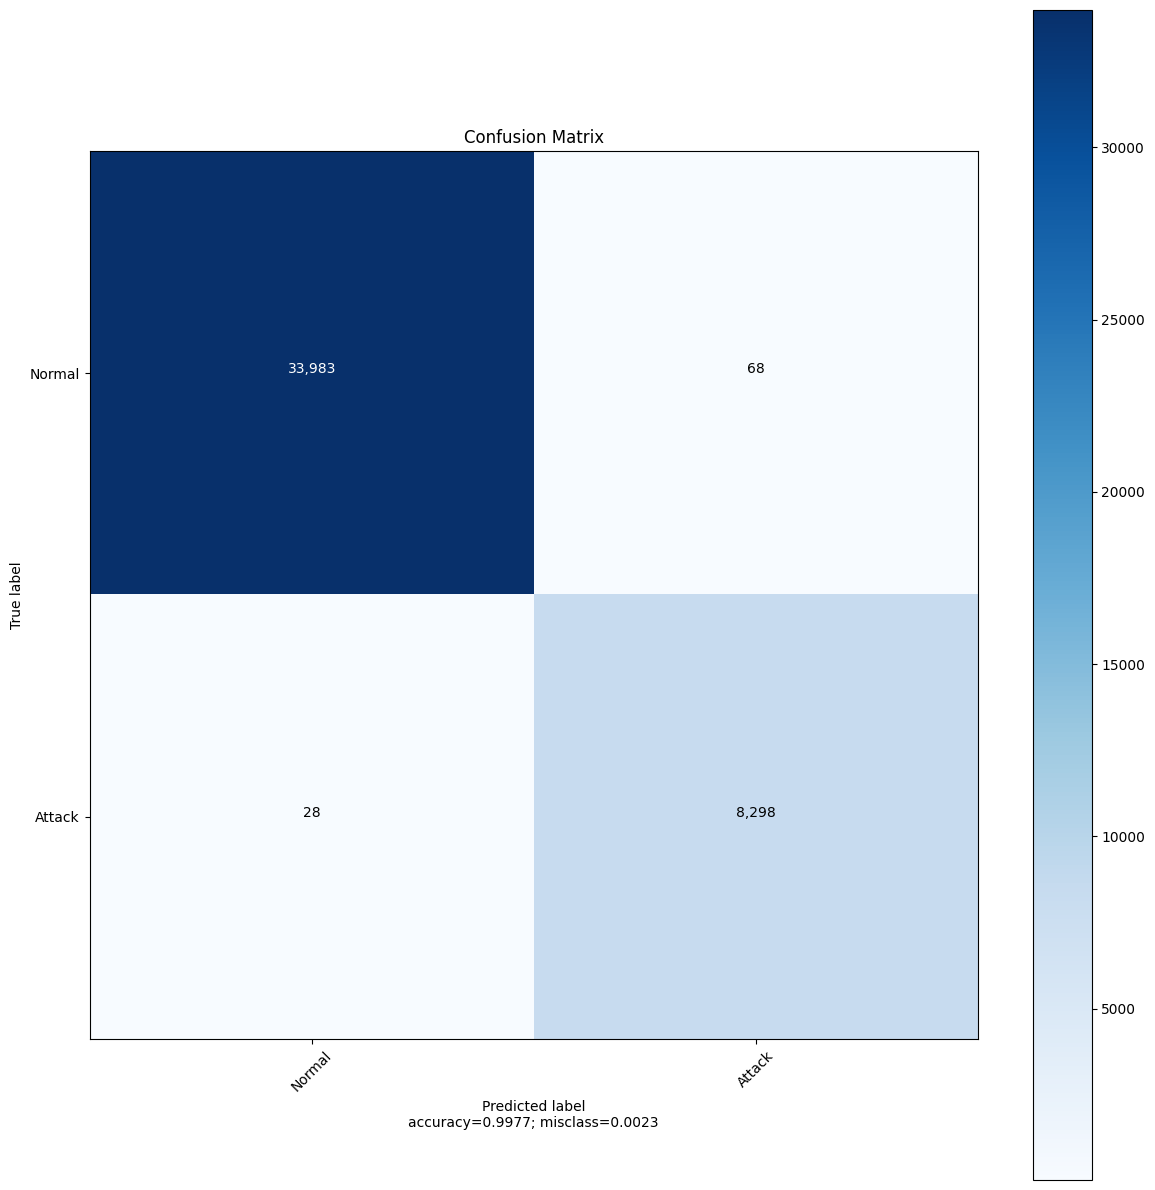

In [53]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat_res.png')

In [54]:
FPR, FNR = calculate_FPR_FNR(cm)

In [55]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat_res"]["elapsed"] = elapsed
results_final["e_gat_res"]["classification_report"] = cr
results_final["e_gat_res"]["FPR"] = FPR
results_final["e_gat_res"]["FNR"] = FNR
results_final["accuracy"]["e_gat_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_gat_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9919    0.9966    0.9942      8326
      Normal     0.9992    0.9980    0.9986     34051

    accuracy                         0.9977     42377
   macro avg     0.9955    0.9973    0.9964     42377
weighted avg     0.9977    0.9977    0.9977     42377



### Saving results

In [56]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()